In [ ]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix
from nilearn.mass_univariate import permuted_ols

# files & sub-ids of connectivity matrices
root = Path("/mnt/raid0/scratch/BIDS/derivatives/nilearn/abend/schaefer200/3_acompcor/correlation/rest")
files = sorted(root.glob("rest_correlation_Schaefer200_16subcort_correction-3_acompcor_sub-*.npy"))
subs = [re.search(r"(sub-\d+)", f.name).group(1) for f in files]


In [27]:
# load factor scores
factorscores = pd.read_csv('/home/leah/Git/BodyWanderingCCA/data/EFAscores.csv')
factorscores = factorscores.set_index("participant_id")
factorscores

,Factor.1,Factor.2
participant_id,,
sub-0039,-1.647755,-0.158554
sub-0019,-1.636191,0.980355
sub-0025,-0.356583,0.835963
sub-0026,-0.197438,0.616814
sub-0021,-0.099891,-0.420825
...,...,...
sub-0628,0.545403,0.015012
sub-0632,0.562637,0.743763
sub-0639,1.529160,2.020250


In [28]:
# intersect & filter to matching subjects (keep file order) 
have_scores = set(factorscores.index)
keep_idx    = [i for i, s in enumerate(subs) if s in have_scores]
subs_keep   = [subs[i] for i in keep_idx]
files_keep  = [files[i] for i in keep_idx]

In [29]:
# load only matching sub-id connectivity matrices 
connect_mats = np.stack([np.load(f) for f in files_keep])  # (n_keep, n_nodes, n_nodes)
factorscores   = factorscores.loc[subs_keep]                 # aligned, no NaNs

print(f"Loaded {len(subs_keep)} matched subjects; connect_mats shape: {connect_mats.shape}; factorscores shape: {factorscores.shape}")

Loaded 493 matched subjects; connect_mats shape: (493, 216, 216); factorscores shape: (493, 2)


In [30]:
# vectorise connect_mats upper triangle (no diagonal)
X = np.array([sym_matrix_to_vec(M, discard_diagonal=True) for M in connect_mats])
X.shape

(493, 23220)

In [31]:
# select factor 1 
Y = factorscores
Y = Y['Factor.1']
Y.shape

(493,)

In [32]:
# run mass-univariate OLS with permutation inference
neg_log_pvals, t_scores, _ = permuted_ols(
    Y, X, n_perm=10000, n_jobs=1, two_sided_test=True, verbose=1
)
#t_scores.shape

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished21 seconds remaining)


In [33]:
neg_log_pvals.shape
t_scores.shape

(1, 23220)

In [34]:
# p-vals are Negative log10 p-values (higher vals = lower the original p-val)
neg_log_pvals
alpha = 1.3 # equivalent to 0.05

# neg_log_p = 1.3  # example value to check conversion
# p_val = 10**(-neg_log_p) 
# p_val

In [35]:
# significant pvals
rows, cols = np.where(neg_log_pvals > 1.3)
sig_pvals = neg_log_pvals[rows, cols]        
sig_pvals

# double check as original pvals:
pvals = 10**(-neg_log_pvals)              # invert -log10 back to 'standard' p-vals
pvals[rows, cols]

array([4.39956004e-03, 2.97970203e-02, 1.67983202e-02, 3.42965703e-02,
       1.91980802e-02, 3.48965103e-02, 1.09989001e-03, 3.99960004e-04,
       3.99960004e-04, 9.99900010e-05, 2.42975702e-02, 4.63953605e-02,
       7.99920008e-03, 3.90960904e-02, 2.47975202e-02, 2.97970203e-02,
       4.06959304e-02])

In [36]:
# flatten (n_edges,) vectors
t_flat = t_scores.ravel()
p_flat = pvals.ravel()

results = pd.DataFrame({
    "edge_index": np.arange(len(t_flat)),
    "t_score": t_flat,
    "p_value": p_flat,
    "neg_log_p": neg_log_pvals.ravel(),
})

In [37]:
# show sig result stats together
alpha = 0.05
sig_edges = results[results["p_value"] < alpha]
sig_edges

,edge_index,t_score,p_value,neg_log_p
69,69,-5.348035,0.004400,2.356591
277,277,-4.838060,0.029797,1.525827
335,335,-4.970628,0.016798,1.774734
2445,2445,4.800979,0.034297,1.464749
2495,2495,4.939254,0.019198,1.716742
2515,2515,4.797613,0.034897,1.457218
5020,5020,5.545845,0.001100,2.958651
5021,5021,5.835804,0.000400,3.397983
5120,5120,5.874268,0.000400,3.397983
5121,5121,6.264126,0.000100,4.000043


In [38]:
# get p & t vals in connectivity matrix shape (only did stats on upper diagonal???? )
from nilearn.connectome import vec_to_sym_matrix

t_mat = vec_to_sym_matrix(t_flat, diagonal=np.zeros(connect_mats.shape[1]))
p_mat = vec_to_sym_matrix(p_flat, diagonal=np.ones(connect_mats.shape[1]))
p_mat.shape
t_mat.shape

(216, 216)

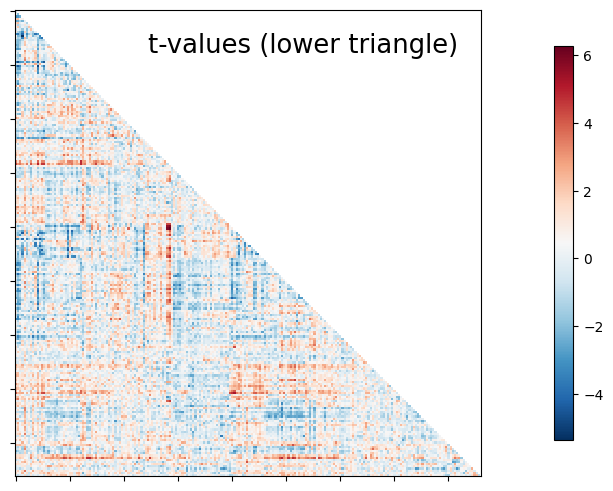

In [39]:
from nilearn.plotting import plot_matrix

plot_matrix(t_mat, figure=(6, 5), tri='lower', cmap='RdBu_r',
            title='t-values (lower triangle)') #tri='full'

In [47]:
# add node (region) labels
labels_df = pd.read_csv('/home/leah/Git/BodyWanderingCCA/data/abend216_yeo7+InteroNetwork.csv')
labels = labels_df['short_labels'].astype(str).tolist()
networks = labels_df['yeo7'].astype(str).tolist()

# Build edge index pairs in the SAME order as sym_matrix_to_vec (upper triangle, no diag)
n_nodes = connect_mats.shape[1]
iu, ju = np.triu_indices(n_nodes, k=1)  # arrays of i,j for each edge


In [48]:
labels_df

,labels,mnicoordsX,mnicoordsY,mnicoordsZ,parcelnum,Juelich.Histological.Atlas,Harvard.Oxford.Cortical.Structural.Atlas,Harvard.Oxford.Subcortical.Structural.Atlas,JHU.ICBM.DTI.81.White.Matter.labels,JHU.White.Matter.tractography.Atlas,Oxford.Thalamic.Connectivity.Atlas,Cerebellar.Atlas.in.MNI152.after.FLIRT,Cerebellar.Atlas.in.MNI152.after.FNIRT,MNI.Structural.Atlas,short_labels,yeo7,merged_labels,yeo7Intero_Shortlabels
0,Schaefer_Left-Vis-1,-23.767013,-52.998385,-9.067128,1001,GM Visual cortex V1 BA17 L,Lingual Gyrus,Left Cerebral Cortex,NaN,NaN,NaN,NaN,NaN,Occipital Lobe,Lingual Gyrus L,Vis,Visual cortex V1 BA17 L,Vis
1,Schaefer_Left-Vis-2,-25.383854,-76.861559,-13.544201,1002,GM Visual cortex V4 L,Occipital Fusiform Gyrus,Left Cerebral Cortex,NaN,Inferior fronto-occipital fasciculus L,NaN,NaN,NaN,Occipital Lobe,Occipital Fusiform Gyrus L,Vis,Visual cortex V4 L,Vis
2,Schaefer_Left-Vis-3,-45.372268,-69.386954,-8.388661,1003,GM Visual cortex V5 L,"Lateral Occipital Cortex, inferior division",Left Cerebral Cortex,NaN,NaN,NaN,NaN,NaN,Occipital Lobe,Lateral Occipital Cortex Inf L,Vis,Visual cortex V5 L,Vis
3,Schaefer_Left-Vis-4,-9.660642,-66.797146,-4.495838,1004,GM Visual cortex V2 BA18 L,Lingual Gyrus,Left Cerebral Cortex,NaN,NaN,NaN,NaN,NaN,Occipital Lobe,Lingual Gyrus L,Vis,Visual cortex V2 BA18 L,Vis
4,Schaefer_Left-Vis-5,-26.609680,-94.857780,-12.330195,1005,GM Visual cortex V3V L,Occipital Pole,Left Cerebral Cortex,NaN,NaN,NaN,NaN,NaN,Occipital Lobe,Occipital Pole L,Vis,Visual cortex V3V L,Vis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Striatum_Left-Putamen,-25.767789,0.860070,0.239517,7003,NaN,NaN,% Left Putamen,NaN,NaN,NaN,NaN,NaN,Putamen,Putamen L,Subcortical,Putamen L,Subcortical
212,Striatum_Right-Accumbens-area,8.626062,11.995751,-7.600567,7004,WM Callosal body,NaN,Right Accumbens,NaN,NaN,NaN,NaN,NaN,Caudate,Accumbens R,Subcortical,Accumbens R,Subcortical
213,Striatum_Right-Caudate,13.583743,11.642916,9.360565,7005,NaN,NaN,Right Caudate,NaN,Anterior thalamic radiation R,NaN,NaN,NaN,Caudate,Caudate R,Subcortical,Caudate R,Subcortical
214,Striatum_Right-Pallidum,21.295860,-3.196734,-1.401443,7006,NaN,NaN,Right Pallidum,NaN,NaN,NaN,NaN,NaN,NaN,Pallidum R,Subcortical,Pallidum R,Subcortical


In [49]:
# Flatten everything to 1-D
t_flat       = np.ravel(t_scores)          # (n_edges,)
neglog_flat  = np.ravel(neg_log_pvals)     # (n_edges,)
p_flat       = 10 ** (-neglog_flat)        # (n_edges,)

# Upper-triangle indices in the SAME order as sym_matrix_to_vec(..., discard_diagonal=True)
n_nodes = connect_mats.shape[1]
iu, ju = np.triu_indices(n_nodes, k=1)

# Sanity checks
assert len(t_flat) == len(neglog_flat) == len(p_flat) == len(iu) == len(ju)

# Build the tidy results table
results = pd.DataFrame({
    "edge": np.arange(len(t_flat)),
    "i": iu,
    "j": ju,
    "roi1": [labels[i] for i in iu],
    "roi2": [labels[j] for j in ju],
    "network1": [networks[i] for i in iu],
    "network2": [networks[j] for j in ju],
    "t_score": t_flat,
    "neg_log10_p": neglog_flat,
    "p_value": p_flat,
})


In [50]:
# num edges of lower triangle (without diagonal)
print(((216*215)/2))
results

23220.0


,edge,i,j,roi1,roi2,network1,network2,t_score,neg_log10_p,p_value
0,0,0,1,Lingual Gyrus L,Occipital Fusiform Gyrus L,Vis,Vis,-0.244083,-0.0,1.0
1,1,0,2,Lingual Gyrus L,Lateral Occipital Cortex Inf L,Vis,Vis,0.232477,-0.0,1.0
2,2,0,3,Lingual Gyrus L,Lingual Gyrus L,Vis,Vis,-2.036368,-0.0,1.0
3,3,0,4,Lingual Gyrus L,Occipital Pole L,Vis,Vis,-2.882291,-0.0,1.0
4,4,0,5,Lingual Gyrus L,Lingual Gyrus L,Vis,Vis,-2.810408,-0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
23215,23215,212,214,Accumbens R,Pallidum R,Subcortical,Subcortical,-0.226095,-0.0,1.0
23216,23216,212,215,Accumbens R,Putamen R,Subcortical,Subcortical,1.315684,-0.0,1.0
23217,23217,213,214,Caudate R,Pallidum R,Subcortical,Subcortical,2.545522,-0.0,1.0
23218,23218,213,215,Caudate R,Putamen R,Subcortical,Subcortical,2.218476,-0.0,1.0


In [51]:
sig_uncorrected = results[results["p_value"] < 0.05]
sig_uncorrected


,edge,i,j,roi1,roi2,network1,network2,t_score,neg_log10_p,p_value
69,69,0,70,Lingual Gyrus L,Precuneous Cortex L,Vis,Cont,-5.348035,2.356591,0.004400
277,277,1,64,Occipital Fusiform Gyrus L,Frontal Pole L,Vis,Cont,-4.838060,1.525827,0.029797
335,335,1,122,Occipital Fusiform Gyrus L,Cingulate Gyrus Post R,Vis,SomMot,-4.970628,1.774734,0.016798
2445,2445,11,147,Cuneal Cortex L,Middle Temporal Gyrus TempOcci R,Vis,SalVentAttn,4.800979,1.464749,0.034297
2495,2495,11,197,Cuneal Cortex L,Precuneous Cortex R,Vis,Default,4.939254,1.716742,0.019198
2515,2515,12,14,Cuneal Cortex L,Planum Polare L,Vis,SomMot,4.797613,1.457218,0.034897
5020,5020,24,161,Superior Parietal Lobule L,Temporal Pole R,SomMot,Limbic,5.545845,2.958651,0.001100
5021,5021,24,162,Superior Parietal Lobule L,Inferior Temporal Gyrus Post R,SomMot,Limbic,5.835804,3.397983,0.000400
5120,5120,25,71,Precentral Gyrus L,Cingulate Gyrus Post L,SomMot,Cont,5.874268,3.397983,0.000400
5121,5121,25,72,Precentral Gyrus L,Cingulate Gyrus Ant L,SomMot,Cont,6.264126,4.000043,0.000100


In [73]:
# save results to plot as chord plot
results.to_csv("/home/leah/Git/BodyWanderingCCA/data/revisions/Factor1connect_massunivariateresults.csv", index=False)
sig_uncorrected.to_csv("/home/leah/Git/BodyWanderingCCA/data/revisions/Factor1connect_massunivariateresults_sigonly.csv", index=False)

In [ ]:
from docx import Document

# Create APA-style subset
apa_table = sig_uncorrected[["roi1", "roi2", "network1", "network2", "t_score", "p_value"]].copy()
apa_table.columns = ["Region 1", "Region 2", "Network 1", "Network 2", "t", "p"]

# Round and format
apa_table["t"] = apa_table["t"].round(3)
apa_table["p"] = apa_table["p"].apply(lambda x: "< .001" if x < 0.001 else f"{x:.3f}")

# Create a new Word document
doc = Document()
doc.add_heading("Table X\nSignificant Edges for Factor 1", level=1)

# Add table
table = doc.add_table(rows=1, cols=len(apa_table.columns))
table.style = "Table Grid"

# Add header row
hdr_cells = table.rows[0].cells
for i, col_name in enumerate(apa_table.columns):
    hdr_cells[i].text = col_name

# Add data rows
for _, row in apa_table.iterrows():
    row_cells = table.add_row().cells
    for i, value in enumerate(row):
        row_cells[i].text = str(value)

# Add APA-style note (optional)
doc.add_paragraph(
    "Note. Values reflect significant edges from the permutation-based mass-univariate ordinary least squares analysis (Factor 1). "
)

# Save file
doc.save("/home/leah/Git/BodyWanderingCCA/data/revisions/Factor1_sig_edges_yeo7_APA.docx")

In [57]:
labels = labels_df['labels'].tolist()   
coords  = labels_df[['mnicoordsX','mnicoordsY','mnicoordsZ']].to_numpy()

/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


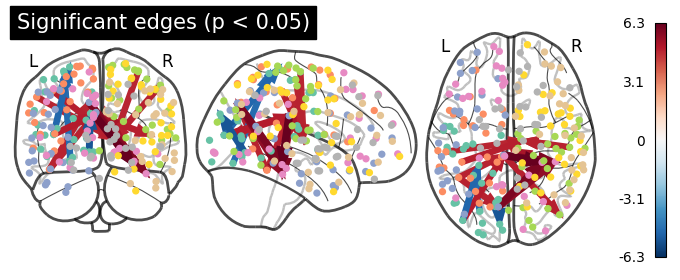

In [ ]:
# plot significant edges
import numpy as np
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix
from nilearn import plotting

# Build coords in the SAME order as your connectome columns 
coords = (labels_df
          .set_index('labels')                              # column with ROI names
          .loc[labels, ['mnicoordsX','mnicoordsY','mnicoordsZ']]
          .to_numpy())

# Rebuild symmetric matrices from the upper-triangle vectors 
n = len(labels)
t_mat = vec_to_sym_matrix(t_flat, diagonal=np.full(n, np.nan))
p_mat = vec_to_sym_matrix(10**(-neglog_flat), diagonal=np.full(n, np.nan))

# Significant-mask (upper triangle, p < 0.05)
upper = np.triu(np.ones((n, n), dtype=bool), k=1)
sig_mask = (p_mat < 0.05) & upper

# Keep only significant t's; zero elsewhere for plotting
W = np.zeros_like(t_mat)
W[sig_mask] = t_mat[sig_mask]

# Symmetric color limits for edges (optional, looks nicer)
v = np.nanmax(np.abs(t_mat[upper]))

# Plot the significant edges 
display = plotting.plot_connectome(
    adjacency_matrix=W,
    node_coords=coords,
    node_size=18,
    edge_cmap='RdBu_r',
    edge_vmin=-v,
    edge_vmax=v,
    display_mode='ortho',   # try 'lzr' or 'xz' etc. if you like
    colorbar=True,
    title='Significant edges (p < 0.05)'
)

# To save:
# display.savefig('sig_edges_connectome.png', dpi=300)
# display.close()


Non-zero nodes: [  0   1  11  12  14  24  25  30  32  64  70  71  72  82  92 122 147 154
 155 161 162 176 180 181 197 210 215]
Their sums: [1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1]


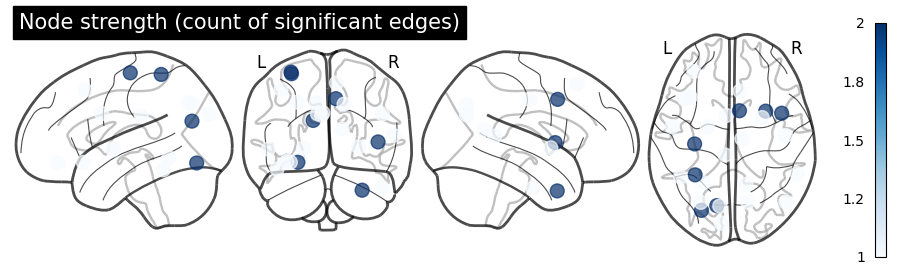

In [ ]:
# plot significant node sums
import numpy as np
from nilearn import plotting

n_nodes = coords.shape[0]

# sig_uncorrected has integer node indices in columns "i" and "j" (0..215)
sig_idx = sig_uncorrected[["i", "j"]].to_numpy(dtype=int)  # shape (n_sig, 2)

# Concatenate endpoints and count how often each node appears (= degree)
all_nodes_in_edges = sig_idx.ravel()  # [i1, j1, i2, j2, ...]
sum_of_connections = np.bincount(all_nodes_in_edges, minlength=n_nodes)

print("Non-zero nodes:", np.where(sum_of_connections > 0)[0])
print("Their sums:", sum_of_connections[sum_of_connections > 0])

# No additional threshold: just use nodes that appear in at least one sig edge
n_connections = 0  # keep all nodes with >0 significant edges

mask = sum_of_connections > n_connections
this_coordinates = coords[mask]
this_sum         = sum_of_connections[mask]

plotting.plot_markers(
    node_coords=this_coordinates,
    node_values=this_sum,
    title="Node strength (count of significant edges)",
    node_cmap="Blues",
    display_mode="lyrz"
)

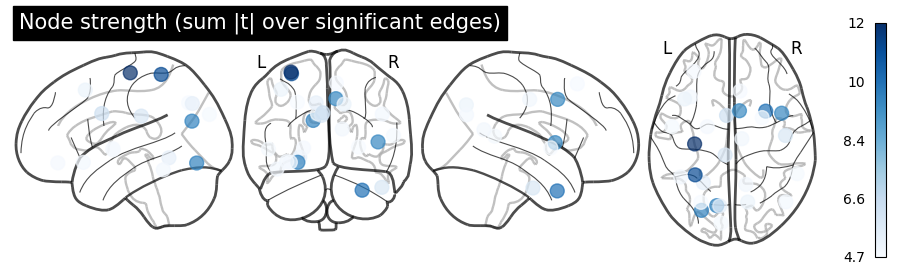

In [ ]:
# plot significant node t-value sums
# Absolute t as edge weight
edge_weights = np.abs(sig_uncorrected["t_score"].to_numpy())

i = sig_uncorrected["i"].to_numpy(dtype=int)
j = sig_uncorrected["j"].to_numpy(dtype=int)

# Each edge contributes its weight to both endpoints
all_nodes = np.concatenate([i, j])
all_weights = np.concatenate([edge_weights, edge_weights])

# sum if same node number
weighted_strength = np.bincount(all_nodes, weights=all_weights, minlength=n_nodes)

mask = weighted_strength > 0
this_coordinates = coords[mask]
this_strength    = weighted_strength[mask]

plotting.plot_markers(
    node_coords=this_coordinates,
    node_values=this_strength,
    title="Node strength (sum |t| over significant edges)",
    node_cmap="Blues",
    display_mode="lyrz"
)


Selected parcels: [1001 1002 1012 1013 1015 1025 1026 1031 1033 1065 1071 1072 1073 1083
 1093 2023 2048 2055 2056 2062 2063 2077 2081 2082 2098 7002 7007]
Values: [1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1]


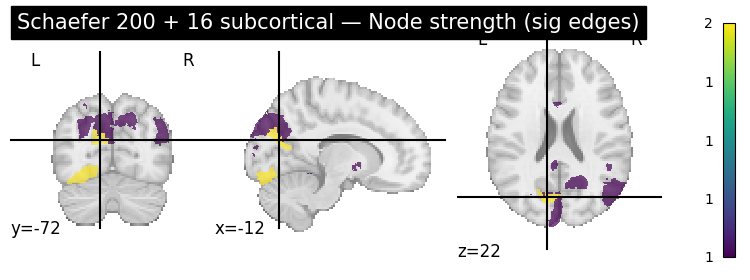

In [ ]:
# plot node sums using schaefer parcels
import numpy as np
import nibabel as nib
from nilearn import plotting

# ---------- 1) Node strength from significant edges ----------
n_nodes = coords.shape[0]

sig_idx = sig_uncorrected[["i", "j"]].to_numpy(dtype=int)
all_nodes = sig_idx.ravel()

sum_of_connections = np.bincount(all_nodes, minlength=n_nodes)

mask = sum_of_connections > 0        # keep nodes that appear in ≥1 sig edge
selected_values  = sum_of_connections[mask]

# parcel IDs must be numeric atlas indices
selected_parcels = labels_df.loc[mask, "parcelnum"].astype(int).to_numpy()

print("Selected parcels:", selected_parcels)
print("Values:", selected_values)

# ---------- 2) Create parcel NIfTI value map ----------
parcel_num   = 200  # 216 (+16 subcortical addons)
combined_atlas = (
    f"/mnt/fast_scratch/Atlases/atlas_abend{parcel_num}"
    f"/atlas_schaefer{parcel_num}_7net_3d.nii.gz"
)

atlas_img   = nib.load(combined_atlas)
parcel_data = atlas_img.get_fdata()

parcel_mask = np.zeros_like(parcel_data, dtype=float)

for pid, val in zip(selected_parcels, selected_values):
    parcel_mask[parcel_data == pid] = val

nifti_image = nib.Nifti1Image(parcel_mask, atlas_img.affine, atlas_img.header)

# ---------- 3) Plot exactly like before ----------
plotting.plot_roi(
    nifti_image,
    cmap='viridis',
    colorbar=True,
    title=f"Schaefer {parcel_num} + 16 subcortical — Node strength (sig edges)"
)
plotting.show()

# save as nifti for plotting mricrogl 
savepath = '/home/leah/Git/BodyWanderingCCA/figures/revisionplots_all/'   
nifti_image = nib.Nifti1Image(parcel_mask.astype(int), atlas_img.affine)
nib.save(nifti_image, f'{savepath}Factor1_MassUnivarCorr_SigNodeSums.nii.gz')

In [91]:
# Find nodes/parcels with exactly 2 significant edges
idx_two = np.where(sum_of_connections == 2)[0]

print("Parcels with exactly 2 significant edges:\n")

for idx in idx_two:
    name       = labels_df.loc[idx, "labels"]      # parcel name
    region     = labels_df.loc[idx, "short_labels"]
    parcel_num = labels_df.loc[idx, "parcelnum"]   # atlas integer ID
    print(f"Node {idx:3d}  |  Parcel {parcel_num:3d}  |  {region}  |  {name} ")


Parcels with exactly 2 significant edges:

Node   1  |  Parcel 1002  |  Occipital Fusiform Gyrus L  |  Schaefer_Left-Vis-2 
Node  11  |  Parcel 1012  |  Cuneal Cortex L  |  Schaefer_Left-Vis-12 
Node  24  |  Parcel 1025  |  Superior Parietal Lobule L  |  Schaefer_Left-SomMot-11 
Node  25  |  Parcel 1026  |  Precentral Gyrus L  |  Schaefer_Left-SomMot-12 
Node 154  |  Parcel 2055  |  Central Opercular Cortex R  |  Schaefer_Right-SalVentAttn-FrOperIns-4 
Node 155  |  Parcel 2056  |  Cingulate Gyrus Ant R  |  Schaefer_Right-SalVentAttn-Med-1 
Node 161  |  Parcel 2062  |  Temporal Pole R  |  Schaefer_Right-Limbic-TempPole-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished36 seconds remaining)
/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


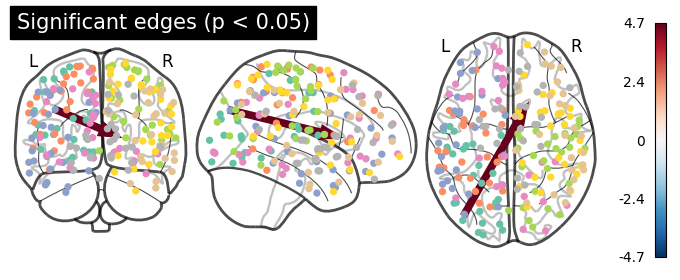

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix
from nilearn import plotting

# Do same for Factor 2
Y2 = factorscores
Y2 = Y2['Factor.2']
Y2.shape

# run mass-univariate OLS with permutation inference - for factor2
neg_log_pvals, t_scores, _ = permuted_ols(
    Y2, X, n_perm=10000, n_jobs=1, two_sided_test=True, verbose=1
)

# double check as original pvals:
pvals = 10**(-neg_log_pvals)              # invert -log10 back to 'standard' p-vals
#pvals[rows, cols]

# Load labels and networks
labels_df = pd.read_csv('/home/leah/Git/BodyWanderingCCA/data/abend216_yeo7+InteroNetwork.csv')

# Extract both columns as lists
labels = labels_df['short_labels'].astype(str).tolist()
networks = labels_df['yeo7'].astype(str).tolist()

# Build the edge index pairs (upper triangle, no diagonal)
n_nodes = connect_mats.shape[1]
iu, ju = np.triu_indices(n_nodes, k=1)
# Flatten results
t_flat = np.ravel(t_scores)
neglog_flat = np.ravel(neg_log_pvals)
p_flat = 10 ** (-neglog_flat)

# Sanity check
assert len(t_flat) == len(iu) == len(ju)

# Build results DataFrame with region + network info
results = pd.DataFrame({
    "edge": np.arange(len(t_flat)),
    "i": iu,
    "j": ju,
    "roi1": [labels[i] for i in iu],
    "roi2": [labels[j] for j in ju],
    "network1": [networks[i] for i in iu],
    "network2": [networks[j] for j in ju],
    "t_score": t_flat,
    "neg_log10_p": neglog_flat,
    "p_value": p_flat,
})

sig_uncorrected = results[results["p_value"] < 0.05]
sig_uncorrected

# save results to plot as chord plot
results.to_csv("/home/leah/Git/BodyWanderingCCA/data/revisions/Factor2connect_massunivariateresults.csv", index=False)
sig_uncorrected.to_csv("/home/leah/Git/BodyWanderingCCA/data/revisions/Factor2connect_massunivariateresults_sigonly.csv", index=False)

labels = labels_df['labels'].tolist()   # or 'label_full' / whatever your column is
#coords  = labels_df[['mnicoordsX','mnicoordsY','mnicoordsZ']].to_numpy()


# Build coords in the SAME order as your connectome columns 
coords = (labels_df
          .set_index('labels')                              # column with ROI names
          .loc[labels, ['mnicoordsX','mnicoordsY','mnicoordsZ']]
          .to_numpy())
# Rebuild symmetric matrices from the upper-triangle vectors 
n = len(labels)
t_mat = vec_to_sym_matrix(t_flat, diagonal=np.full(n, np.nan))
p_mat = vec_to_sym_matrix(10**(-neglog_flat), diagonal=np.full(n, np.nan))
# Significant-mask (upper triangle, p < 0.05) 
upper = np.triu(np.ones((n, n), dtype=bool), k=1)
sig_mask = (p_mat < 0.05) & upper
# Keep only significant t's; zero elsewhere for plotting
W = np.zeros_like(t_mat)
W[sig_mask] = t_mat[sig_mask]
# Symmetric color limits for edges (optional, looks nicer)
v = np.nanmax(np.abs(t_mat[upper]))
# Plot the significant edges 
display = plotting.plot_connectome(
    adjacency_matrix=W,
    node_coords=coords,
    node_size=18,
    edge_cmap='RdBu_r',
    edge_vmin=-v,
    edge_vmax=v,
    display_mode='ortho',   # try 'lzr' or 'xz' etc. if you like
    colorbar=True,
    title='Significant edges (p < 0.05)'
)

# To save:
# display.savefig('sig_edges_connectome.png', dpi=300)
# display.close()


Selected parcels: [2082 7006]
Values: [1 1]


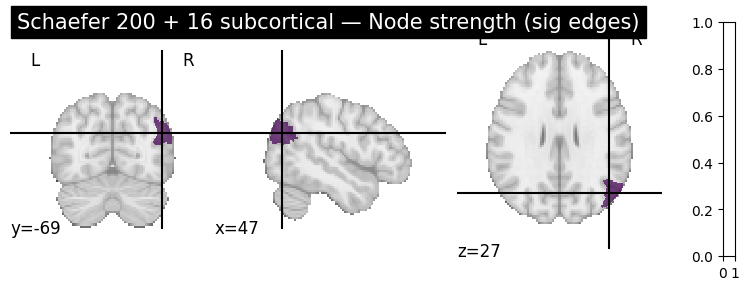

In [ ]:
# plot node sums using schaefer parcels - for Factor 2
import numpy as np
import nibabel as nib
from nilearn import plotting

# Node strength from significant edges 
n_nodes = coords.shape[0]

sig_idx = sig_uncorrected[["i", "j"]].to_numpy(dtype=int)
all_nodes = sig_idx.ravel()

sum_of_connections = np.bincount(all_nodes, minlength=n_nodes)

mask = sum_of_connections > 0        # keep nodes that appear in ≥1 sig edge
selected_values  = sum_of_connections[mask]

# parcel IDs must be numeric atlas indices
selected_parcels = labels_df.loc[mask, "parcelnum"].astype(int).to_numpy()

print("Selected parcels:", selected_parcels)
print("Values:", selected_values)

# Create parcel NIfTI value map 
parcel_num   = 200  # 216 (+16 subcortical addons)
combined_atlas = (
    f"/mnt/fast_scratch/Atlases/atlas_abend{parcel_num}"
    f"/atlas_schaefer{parcel_num}_7net_3d.nii.gz"
)

atlas_img   = nib.load(combined_atlas)
parcel_data = atlas_img.get_fdata()

parcel_mask = np.zeros_like(parcel_data, dtype=float)

for pid, val in zip(selected_parcels, selected_values):
    parcel_mask[parcel_data == pid] = val

nifti_image = nib.Nifti1Image(parcel_mask, atlas_img.affine, atlas_img.header)

# Plot 
plotting.plot_roi(
    nifti_image,
    cmap='viridis',
    colorbar=True,
    title=f"Schaefer {parcel_num} + 16 subcortical — Node strength (sig edges)"
)
plotting.show()

# save as nifti for plotting mricrogl 
savepath = '/home/leah/Git/BodyWanderingCCA/figures/revisionplots_all/'   
nifti_image = nib.Nifti1Image(parcel_mask.astype(int), atlas_img.affine)
nib.save(nifti_image, f'{savepath}Factor2_MassUnivarCorr_SigNodeSums.nii.gz')

